In [40]:
import numpy as np 
import matplotlib.pyplot as plt
from random import randint
import random
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

In [2]:
# Task 1
def init_q_table(n_states, n_actions):
    return np.zeros((n_states,n_actions))


def q_update(Q,s,a,r,s_next,alpha,gamma):
    Q[s,a] = Q[s,a] + alpha*(r+gamma*(np.max(Q[s_next]))-Q[s,a])
# np.max() returns the maximum value from all possible actions of s_next state
    return Q


In [3]:
# Task 2
# Part 1 : GridWorld Definition

grid = [ [ 0, 0, 0,-1],
         [ 0,-1, 0, 0],
         [ 0, 0,-1, 0],
         [-1, 0, 0, 1]
        ]

# print(grid)
# Stepping on -1 or 1 ends the episode, 1 is the final goal while -1 are traps

# A variable state to define the current position in the grid
state = [None,None] 

# For every episode, we will be randomly assigning the starting point
def reset():
    # global state
    while True:
        x = randint(0, 3)
        y = randint(0, 3)
        if grid[x][y] == 0:  # not a trap or goal
            state = [x, y]
            return state


# Given current state and action, return the next state, reward, and if episode is over
def step(state, action):
    x, y = state  

    # Move according to action (up, down, right, left)
    if action == 0 and x > 0:        # up
        x -= 1
    elif action == 1 and x < 3:      # down
        x += 1
    elif action == 2 and y < 3:      # right
        y += 1
    elif action == 3 and y > 0:      # left
        y -= 1
    else:
        return state, -5, False  # invalid move

    next_state = [x, y]
    value = grid[x][y]

    if value == -1:
        return next_state, -1, True
    elif value == 1:
        return next_state, 10, True
    else:
        return next_state, 0, False

# Part 2: Epsilon-Greedy Action Selection
def select_action(Q, state, epsilon):
    var = random.random()
    if var < epsilon : 
        return randint(0,3)
    else:
        return np.argmax(Q[state])


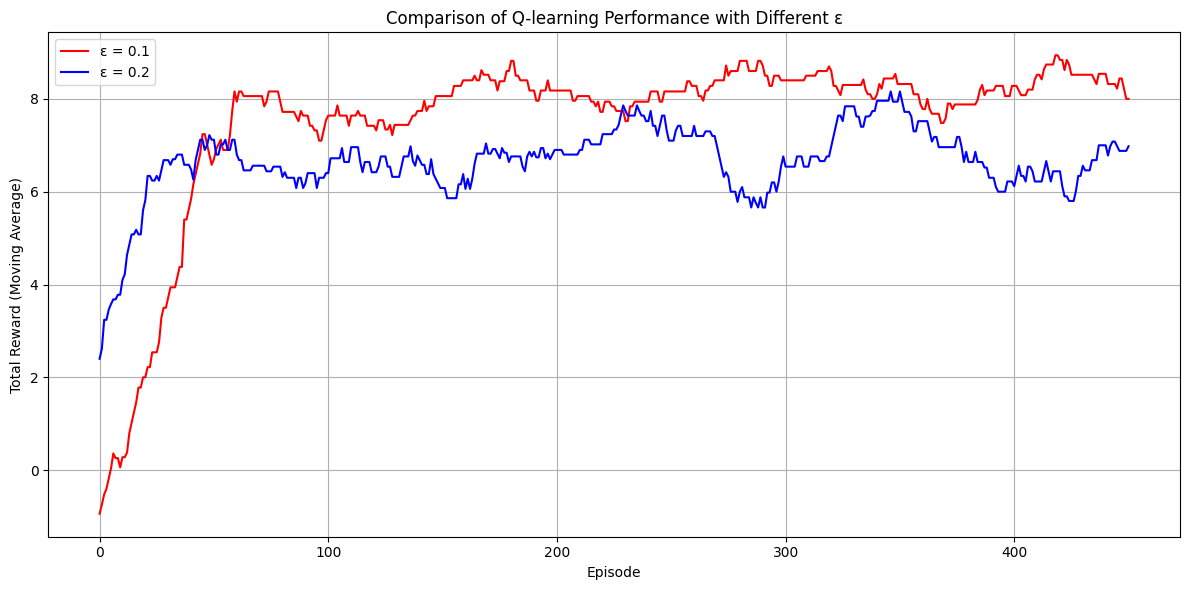

In [ ]:
# Part 3: Training and Eval
alpha = 0.1
gamma = 0.95

def train(epsilon):
    Q = init_q_table(16,4)
    total_reward = []
    for i in range(500):
        state = reset()
        done = False
        total_reward_in_one_episode = 0
        while(done == False):
            state_one_dim = 4*state[0] + state[1]
            action = select_action(Q,state_one_dim,epsilon)
            next_state, reward, done = step(state, action)
            next_state_one_dim = 4*next_state[0] + next_state[1]
            total_reward_in_one_episode += reward
            Q = q_update(Q, state_one_dim, action, reward, next_state_one_dim,alpha, gamma)
            state = next_state
        total_reward.append(total_reward_in_one_episode)
    return total_reward

def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
# Moving average can be thought of as an array being convolved with another array having each value as 1/window_size
# This takes the average of values in groups of 50, and the kernel moves one step at a time
rewards_one = train(0.1)
rewards_two = train(0.2)

# Compute moving averages
ma_one = moving_average(rewards_one, window_size=50)
ma_two = moving_average(rewards_two, window_size=50)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(ma_one, label='ε = 0.1', color='red')
plt.plot(ma_two, label='ε = 0.2', color='blue')
plt.xlabel('Episode')
plt.ylabel('Total Reward (Moving Average)')
plt.title('Comparison of Q-learning Performance with Different ε')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Blue line respresents when we allow the model to explore more(larger epsilon). However we see that the model does not learns better as compared to the red line, which indicates that for our environment epsilon value of around 0.1 is sufficient, and it allows the model to explore well enough.

Also, due to more randomness in the moves of blue line even after learning, we have more noice even after a few hundred episodes, as it is still making bad decisions even after learning. The noice in red graph is much lesser, as it makes less random decisions.

During the initial phase, allowing more exploration helps the model to learn better, hence the optimal approach should be using an epsilon which decays as the model learns.

In [ ]:
# Task 3
# Part 1: Replay Buffer Implementation
from collections import deque
# Using deque as it is more efficient than lists, and optimized for fasters appends and pop from both ends
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def push(self,state,action,reward,next_state,done):
        transition_tuple = (state,action,reward,next_state,done)
        self.buffer.append(transition_tuple)
        return self.buffer
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        # extracts all parameters from batch
        states, actions, rewards, next_states, dones = zip(*batch)
    
    # Convert to numpy arrays with proper shapes
        states = np.array(states, dtype=np.float32)
        next_states = np.array(next_states, dtype=np.float32)
        actions = np.array(actions, dtype=np.int64)
        rewards = np.array(rewards, dtype=np.float32)
        dones = np.array(dones, dtype=np.bool8)
    
        return states, actions, rewards, next_states, dones

    def len(self):
        return len(self.buffer)
# Part 2: Buffer Demonstration
sample_buffer = ReplayBuffer(100)
for i in range(100):
    state = (randint(0,1000),randint(0,1000))
    next_state = (randint(0,1000),randint(0,1000))
    action = randint(0,10)
    reward = 10*random.random()
    done_decider = random.random()
    if done_decider < 0.5:
        done = False
    else:
        done = True
    sample_buffer.push(state,action,reward,next_state, done)
sample_state, sample_action,sample_reward,sample_next_state, sample_done = sample_buffer.sample(32)
print(np.shape(sample_state), sample_state.dtype)
print(np.shape(sample_action), sample_action.dtype)
print(np.shape(sample_reward), sample_reward.dtype)
print(np.shape(sample_done), sample_done.dtype)




(32, 2) float32
(32,) int64
(32,) float32
(32,) bool


In [ ]:
# Task 4
# Part 1: DQN Network Architectures
import torch
import torch.nn as nn
import torch.nn.functional as F


class DQNPolicy(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNPolicy, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)   # First hidden layer
        self.fc2 = nn.Linear(128, 128)         # Second hidden layer
        self.out = nn.Linear(128, output_dim)  # Output layer

    # x is the input for the Neural Networks
    def forward(self, x):
        x = F.relu(self.fc1(x))   # Apply ReLU to first hidden layer
        x = F.relu(self.fc2(x))   # Apply ReLU to second hidden layer
        return self.out(x)        # Sends the result to the output layer

# Same thing done again for target network
class DQNTarget(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNTarget, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

# Part 2: Target Network Update

def update_target(policy_net, target_net):
    target_net.load_state_dict(policy_net.state_dict())
# state_dict() gives the weights of policy_net as a dictionary, then it is loaded as a dictionary in the target_net

Final Success Rate: 55.00%


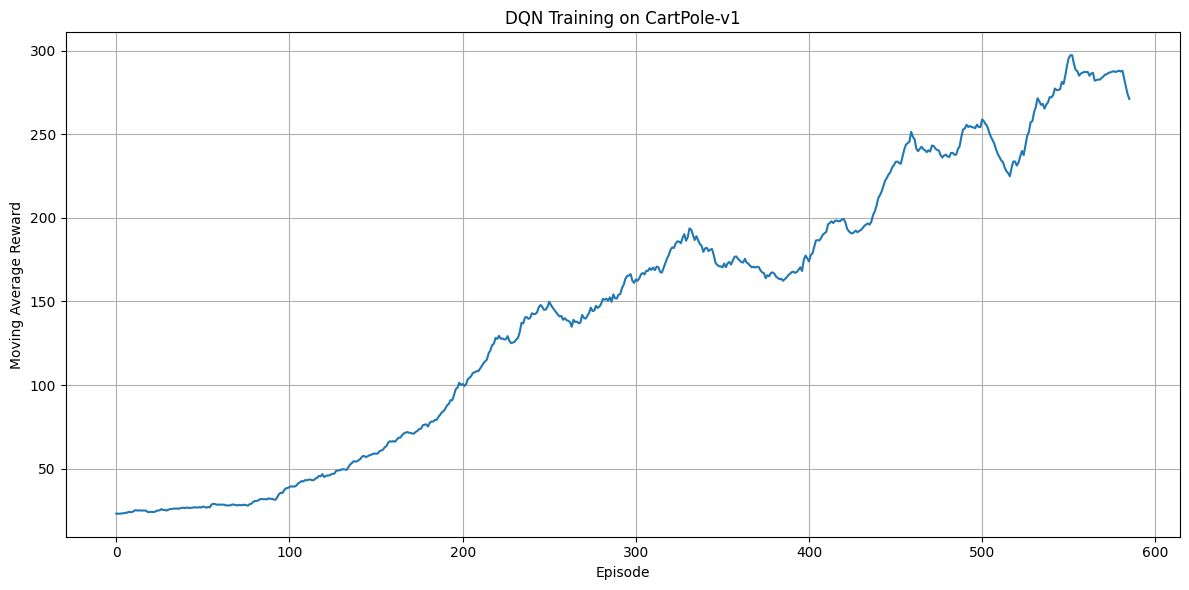

In [ ]:
# Task 5
import gym
import torch.nn as nn
import torch.optim as optim


# --- Hyperparameters ---
no_of_episode = 650
N = 2
# train every N steps
M = 1.2
TARGET_UPDATE_FREQ = 5
batch_size = 64
gamma = 0.99
LR = 0.0005
capacity = 10000

# Loading the environment
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
# Initializing two Neural Networks
policy_net = DQNPolicy(state_dim, action_dim)
target_net = DQNTarget(state_dim, action_dim)
update_target(policy_net, target_net)
# Initializing a loss function, adam optimizer, and a buffer object
optimizer = optim.Adam(policy_net.parameters(), lr=LR)
loss_fn = nn.MSELoss()
buffer = ReplayBuffer(capacity)

# A list where all episode rewards are going to be updated
episode_rewards = []
train_step = 0

for episode in range(no_of_episode):
    # Getting the initial state of the environment
    state, _ = env.reset()
    done = False
    epsilon = max(0.01, 1.0 - (episode / no_of_episode)*M)
    total_reward = 0

    while done != True:
        if random.random() < epsilon:
            action = env.action_space.sample()
            # Selects a random action from the set of possible actions 
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                q_values = policy_net(state_tensor)
                action = torch.argmax(q_values).item()

        # next_state, reward, done, _ ,info= env.step(action)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        train_step+=1

        if buffer.len() >= batch_size and train_step %N==0:
            states, actions, rewards, next_states, dones = buffer.sample(batch_size)

            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions).unsqueeze(1)
            rewards = torch.FloatTensor(rewards).unsqueeze(1)
            next_states = torch.FloatTensor(next_states)
            dones = torch.BoolTensor(dones).unsqueeze(1)

            q_values = policy_net(states).gather(1, actions)
            next_q_values = target_net(next_states).max(1, keepdim=True)[0]
            targets = rewards + gamma * next_q_values * (~dones)

            loss = loss_fn(q_values, targets.detach())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    episode_rewards.append(total_reward)

    if episode % TARGET_UPDATE_FREQ == 0:
        update_target(policy_net, target_net)

# Essentially what we want is that the overall update happening starts to stabilize after a set number of epochs
# hence we want the diff between the policy net and the target net to be minimized after a particular point
# 
# --- Evaluation ---
window = no_of_episode // 10
moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
success_rate = 100 * sum([r >= 195 for r in episode_rewards[-100:]]) / 100

print(f"Final Success Rate: {success_rate:.2f}%")

plt.figure(figsize=(12, 6))
plt.plot(moving_avg)
plt.xlabel("Episode")
plt.ylabel("Moving Average Reward")
plt.title("DQN Training on CartPole-v1")
plt.grid()
plt.tight_layout()
plt.show()


Hyperparameters:
The total number of episodes is 650, as it is sufficient to get decently high reward in the later episodes. Also, I am training the model every 2 steps, which does sacrifice a bit of performance for faster training. The rate at which epsilon decays is 1.2, a small number so that the model has sufficient training in the initial stage. I took a small learning rate, as larger values were not efficient was training. 

For neural networks, we use two neural networks. policy_net is used for selecting actions,target_net is used to make stable targets during training.
Weights are copied from policy_net to target_net after every 5 episodes

Since the dimensions of state, action, reward etc. are different, I made numpy arrays of each individually. when the length of the buffer exceeds a batch size, we convert all numpy arrays into Tensors, adjust the dimensions(to send to the NN) and then compute the loss function, and propagate the backward.
All the rewards for each episode are appended into a list, which is later plotted.